# Problem Statement

Expedia receives millions of users per day who are hoping to plan and book their ideal vacation. They are trying to find a better way to offer the best hotels for the customer so they can easily book the hotel of their choosing. More bookings means an increase Expedia's overall revenue.

Expedia is interested in predicting which hotel group a user is going to book. Expedia has in-house algorithms to form hotel clusters, where similar hotels for a search (based on historical price, customer star ratings, geographical locations relative to city center, etc) are grouped together. These hotel clusters serve as identifiers to which types of hotels people are going to book, while avoiding outliers such as new hotels that don't have historical data.

My goal is to predict the "hotel cluster" for a user based on their search criteria and attributes.

# About the the Data

I received the data from Kaggle. I was given a training set and test set. For this analysis, I will be using only the training set as the test set is for Kaggle submissions. The training set consisted of random searches from Jan 2013 - Dec 2014.

An important thing to note, the data is completely anonymized. Anything in relation to a location or name was given a numerical value. This really limited what insights I could draw from the data except from what was on the surface level.

## Data Dictionary

|Column name|Description|Data type|
|-----------|-----------|---------|
|date_time|Timestamp|string|
|site_name|ID of the Expedia point of sale(i.e.Expedia.com,Expedia.co.uk, Expedia.co.jp, ...)|int|
|posa_continent|ID of continent associated with site_name|int|
|user_location_country|The ID of the country the customer is located|int|
|user_location_region|The ID of the region the customer is located|int|
|user_location_city|The ID of the city the customer is located	|int|
|orig_destination_distance|Physical distance between a hotel and a customer at the time of search. A null means the distance could not be calculated|float|
|user_id|ID of user|int|
|is_mobile|1 when a user connected from a mobile device, 0 otherwise|int|
|is_package|1 if the click/booking was generated as a part of a package (i.e. combined with a flight), 0 otherwise|int|
|channel|ID of a marketing channel|int|
|srch_ci|Checkin date|string|
|srch_co|Checkout date|string|
|srch_adults_cnt|The number of adults specified in the hotel room|int|
|srch_children_cnt|The number of (extra occupancy) children specified in the hotel room|int|
|srch_rm_cnt|The number of hotel rooms specified in the search	|int|
|srch_destination_id|ID of the destination where the hotel search was performed|int|
|srch_destination_type_id|Type of destination|int|
|hotel_continent|Hotel continent|int|
|hotel_country|Hotel country|int|
|hotel_market|Hotel market|int|
|is_booking|1 if a booking, 0 if a click|int|
|cnt|Numer of similar events in the context of the same user session|int|
|hotel_cluster|ID of a hotel cluster|int|

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.cross_validation import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

//anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [2]:
expedia = pd.read_csv("../../Datasets/Expedia Data/train.csv", nrows=20000)

In [3]:
expedia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 24 columns):
date_time                    20000 non-null object
site_name                    20000 non-null int64
posa_continent               20000 non-null int64
user_location_country        20000 non-null int64
user_location_region         20000 non-null int64
user_location_city           20000 non-null int64
orig_destination_distance    11868 non-null float64
user_id                      20000 non-null int64
is_mobile                    20000 non-null int64
is_package                   20000 non-null int64
channel                      20000 non-null int64
srch_ci                      19988 non-null object
srch_co                      19988 non-null object
srch_adults_cnt              20000 non-null int64
srch_children_cnt            20000 non-null int64
srch_rm_cnt                  20000 non-null int64
srch_destination_id          20000 non-null int64
srch_destination_type_id     20000 n

In [4]:
expedia.head(3)

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,0,1,8250,1,0,1,2,50,628,1


In [5]:
exp = pd.DataFrame(expedia)

In [6]:
exp['date_time'] = pd.to_datetime(exp['date_time'])
exp['srch_ci'] = pd.to_datetime(exp['srch_ci'])
exp['srch_co'] = pd.to_datetime(exp['srch_co'])

# Summary Statistics

66     11016
69      2067
205     1386
3        897
46       829
23       398
70       276
62       228
77       194
231      189
Name: user_location_country, dtype: int64


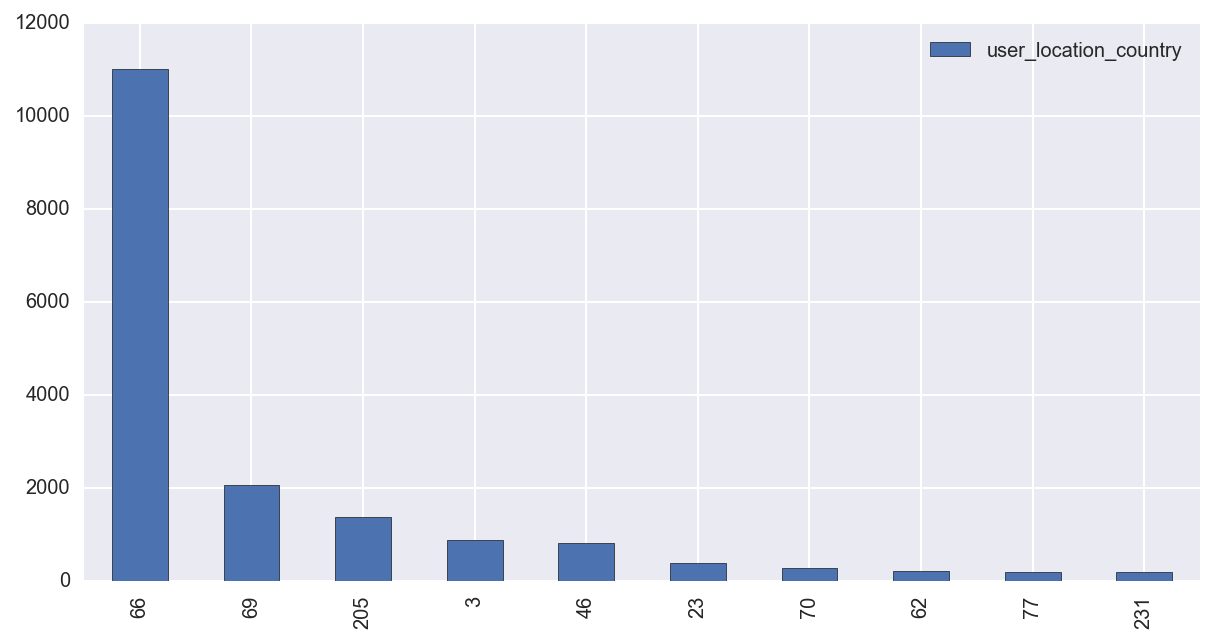

In [7]:
# What country are most of the searches from?

print exp['user_location_country'].value_counts().head(10)

plt.figure(figsize=(10,5))
exp['user_location_country'].value_counts().head(10).plot(legend=True, kind='bar')

In [8]:
# Booked subset
booked = exp[exp['is_booking'] == 1]

0    18421
1     1579
Name: is_booking, dtype: int64


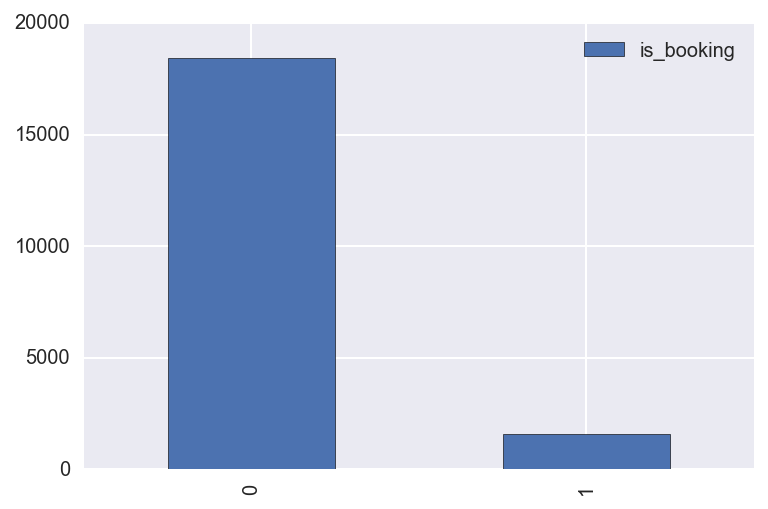

In [59]:
# How many bookings?

print exp['is_booking'].value_counts()
exp['is_booking'].value_counts().plot(legend=True, kind='bar')

0    15013
1     4987
Name: is_package, dtype: int64


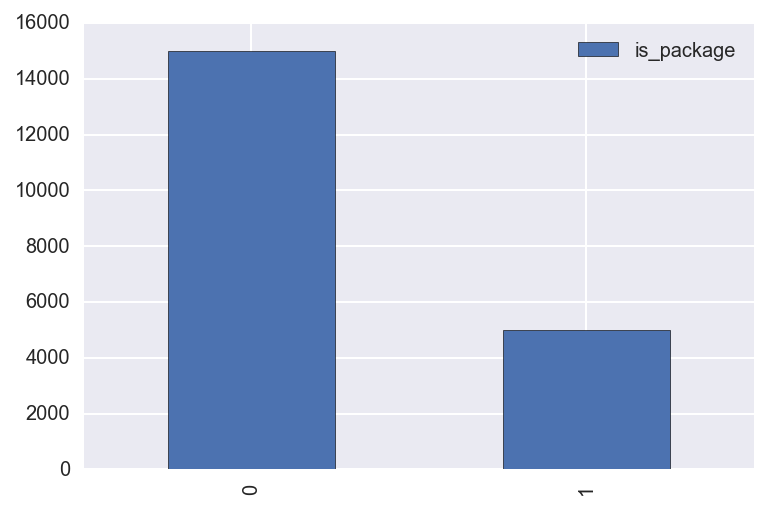

In [10]:
# Packages
# Packages booked packages

print exp['is_package'].value_counts()
exp['is_package'].value_counts().plot(legend=True, kind='bar')

0    16840
1     3160
Name: is_mobile, dtype: int64


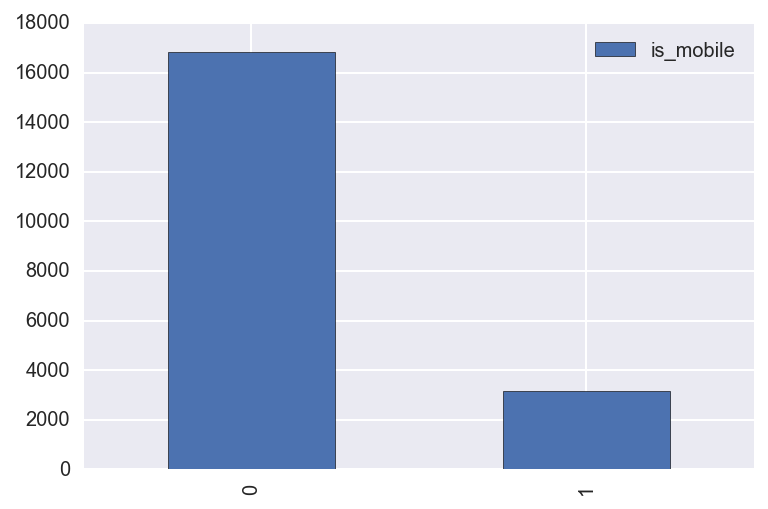

In [11]:
# Mobile
# booked Mobile
# booked mobile, that is a package

print exp['is_mobile'].value_counts()
exp['is_mobile'].value_counts().plot(legend=True, kind='bar')

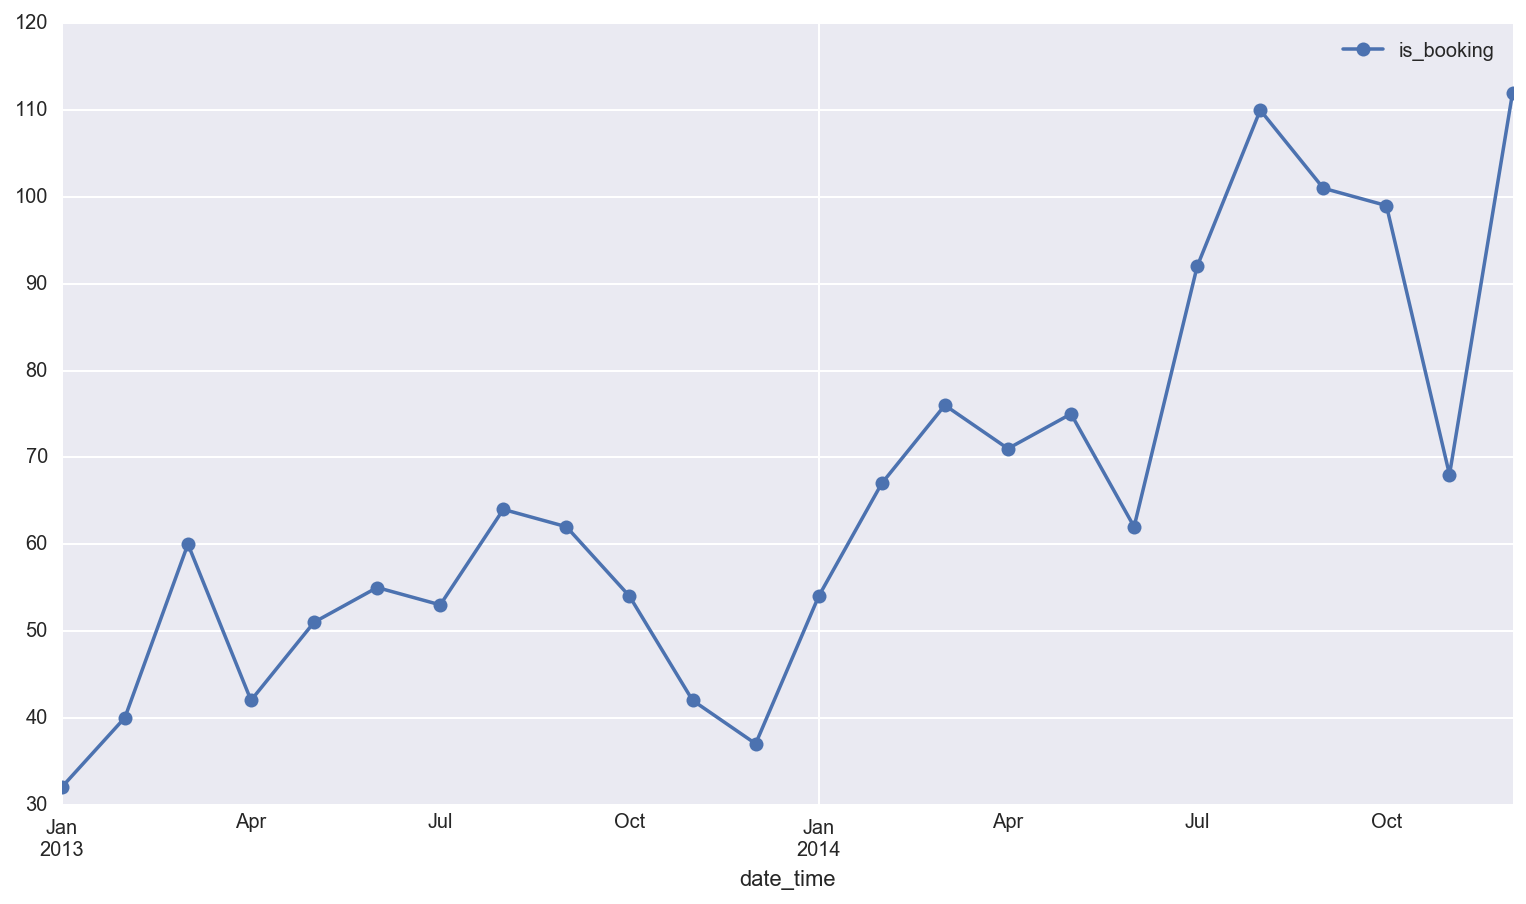

In [42]:
# The number of bookings during the year

date_booked = booked.groupby(booked.date_time.dt.to_period("M"))['is_booking'].sum()

fig = plt.figure(figsize=(13,7))

date_booked.plot(legend=True, marker='o')

In [12]:
# Create a copy and remove features that do not relate to hotel cluster
exp2 = exp.copy()

exp2.drop(exp2[['date_time', 'srch_ci', 'srch_co', 'channel', 
                'orig_destination_distance', 'hotel_cluster']], axis=1, inplace=True)

In [13]:
X_cols = exp2.columns
X = exp2[X_cols].values
Y = expedia.hotel_cluster.values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

# Baseline Accuracy

Our baseline accuracy for the data is 2%. This indicates if someone were to guess which hotel a user will book, the liklihood of them guessing correctly would be 2%.

In [14]:
# find the mode of the dataset
from scipy.stats import mode
modearray = mode(Y)
print modearray

ModeResult(mode=array([91]), count=array([476]))


In [15]:
baseline = modearray[1][0]/float(Y.shape[0])
print "baseline score: ", baseline

baseline score:  0.0238


# Modeling

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### Decision Tree

I chose a decision to try and find my best predictors.

In [17]:
dtc = DecisionTreeClassifier()

In [55]:
dtc_params = {
    'criterion':['gini','entropy'],
    'max_features':['auto', None],
    'max_depth':[None,3,4,5],
    'min_samples_split':[2,3,4,5],
    'min_samples_leaf':[1,3,5,7]
}

dtc_gs = GridSearchCV(dtc, dtc_params, cv=5, n_jobs=-1)

In [56]:
import time
def dtc_fit(model_gs, X, y):
    start = time.time()
    model_gs.fit(X,y)
    print "Runtime: %0.3f"%(time.time() - start)
    print "Gridsearch score: %0.4f"%(model_gs.best_score_)
    print "Best parameter: ", model_gs.best_params_

dtc_fit(dtc_gs, X_train, Y_train)

Runtime: 28.089
Gridsearch score: 0.2466
Best parameter:  {'max_features': None, 'min_samples_split': 2, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1}


In [43]:
dtc_best = dtc_gs.best_estimator_.fit(X_train, Y_train)

In [44]:
dtc_best.score(X_test, Y_test)

0.26483333333333331

In [45]:
pd.DataFrame({'feature':X_cols, 'importance':dtc_best.feature_importances_}).sort_values(by='importance', 
                                                                                         ascending=False)

,feature,importance
17,hotel_market,0.208411
15,hotel_continent,0.120428
5,user_id,0.117218
4,user_location_city,0.096832
11,srch_destination_id,0.083084
3,user_location_region,0.076564
16,hotel_country,0.068499
14,cnt,0.059505
12,srch_destination_type_id,0.031895
8,srch_adults_cnt,0.030925


### Random Forest

In [46]:
rf = RandomForestClassifier()

In [24]:
rf_params = {
    'n_estimators':[10,20,30],
    'criterion':['gini','entropy'],
    'max_features':['auto',None],
    'max_depth':[None,2,3,4,5],
    'warm_start':[True]
}

rf_gs = GridSearchCV(rf, rf_params, cv=5, n_jobs=-1)

[CV] max_features=auto, min_samples_split=3, criterion=entropy, max_depth=5, min_samples_leaf=7 
[CV] max_features=None, min_samples_split=3, criterion=entropy, max_depth=5, min_samples_leaf=3 
[CV]  max_features=auto, min_samples_split=2, criterion=entropy, max_depth=5, min_samples_leaf=7 -   0.0s
[CV]  max_features=None, min_samples_split=3, criterion=entropy, max_depth=5, min_samples_leaf=1 -   0.1s[CV]  max_features=auto, min_samples_split=3, criterion=entropy, max_depth=5, min_samples_leaf=7 -   0.1s[CV]  max_features=None, min_samples_split=3, criterion=entropy, max_depth=5, min_samples_leaf=3 -   0.1s[CV] max_features=auto, min_samples_split=2, criterion=entropy, max_depth=5, min_samples_leaf=7 



[CV]  max_features=auto, min_samples_split=2, criterion=entropy, max_depth=5, min_samples_leaf=7 -   0.0s
[CV] max_features=None, min_samples_split=3, criterion=entropy, max_depth=5, min_samples_leaf=1 
[CV] max_features=None, min_samples_split=2, criterion=entropy, max_depth=5, min_s

In [25]:
import time
def rf_fit(model_gs, X, y):
    start = time.time()
    model_gs.fit(X,y)
    print "Runtime: %0.3f"%(time.time() - start)
    print "Gridsearch score: %0.4f"%(model_gs.best_score_)
    print "Best parameter: ", model_gs.best_params_

rf_fit(rf_gs, X_train, Y_train)

Runtime: 108.403
Gridsearch score: 0.2662
Best parameter:  {'max_features': None, 'n_estimators': 30, 'criterion': 'entropy', 'warm_start': True, 'max_depth': None}


In [26]:
# Fit my training data to my best parameters
rf_best = rf_gs.best_estimator_
rf_best.fit(X_train, Y_train)

//anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:267: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=None, verbose=0, warm_start=True)

In [27]:
print "Best Score", rf_best.score(X_test, Y_test)

Best Score 0.283666666667


In [28]:
rf_predictions = rf_best.predict(X_test)
rf_confusion_matrix = pd.crosstab(Y_test, rf_predictions, rownames=['Actual'], colnames=['Predicted'])
# rf_confusion_matrix

In [29]:
rf_predictions

array([83, 62, 49, ..., 11, 94, 89])

In [48]:
print '\nClassification report for the Random Forest:\n\n', classification_report(Y_test, rf_predictions)


Classification report for the Random Forest:

             precision    recall  f1-score   support

          0       0.27      0.46      0.34        41
          1       0.39      0.60      0.48        50
          2       0.32      0.34      0.33        64
          3       0.25      0.18      0.21        39
          4       0.22      0.25      0.23        53
          5       0.20      0.17      0.18        84
          6       0.21      0.25      0.22        61
          7       0.31      0.31      0.31        42
          8       0.39      0.53      0.45        92
          9       0.19      0.24      0.21        55
         10       0.21      0.24      0.22        51
         11       0.27      0.26      0.27        53
         12       0.42      0.38      0.40        68
         13       0.41      0.32      0.36        59
         14       0.24      0.26      0.25        35
         15       0.19      0.15      0.17        52
         16       0.32      0.26      0.29        8

In [31]:
# pred_bin = []
# for a, b in zip(rf_predictions, Y_test):
#     if a == b:
#         pred_bin.append(1)
#     else:
#         pred_bin.append(0)

# df_ = {"predicted_val": rf_predictions, "actual_val": Y_test, "bin_pred": pred_bin}

# df_ = pd.DataFrame(df_)

In [32]:
# df_['bin_pred'].value_counts()

### KNeighbors Classifier

I chose a KNeighbors Classifier because it is a simple and easy model, yet can be effective when trying to find similar points that are close to each other.

In [33]:
knn = KNeighborsClassifier()

In [34]:
# hone in on parameters
knn_params = {
    'n_neighbors':range(15,30,1), # tuning from 2 - 30
    'weights':['distance'],
    'algorithm':['ball_tree','kd_tree','brute'],
    'metric':['euclidean','manhattan']
}

knn_gs = GridSearchCV(knn, knn_params, cv=5, n_jobs=-1)

In [35]:
import time
def knn_fit(model_gs, X, y):
    start = time.time()
    model_gs.fit(X,y)
    print "Runtime: %0.3f"%(time.time() - start)
    print "Gridsearch score: %0.4f"%(model_gs.best_score_)
    print "Best parameter: ", model_gs.best_params_

knn_fit(knn_gs, X_train, Y_train)

Runtime: 94.362
Gridsearch score: 0.2572
Best parameter:  {'n_neighbors': 20, 'metric': 'manhattan', 'weights': 'distance', 'algorithm': 'kd_tree'}


In [36]:
knn_best = knn_gs.best_estimator_
knn_best.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='distance')

In [37]:
print "Best Score", knn_best.score(X_test, Y_test)

Best Score 0.2755


In [39]:
knn_predictions = knn_best.predict(X_test)
knn_confusion_matrix = pd.crosstab(Y_test, knn_predictions, rownames=['Actual'], colnames=['Predicted'])

In [40]:
knn_predictions

array([ 5, 62, 49, ..., 11, 21, 89])

In [49]:
print '\nClassification report for the KNN:\n\n', classification_report(Y_test, knn_predictions)


Classification report for the KNN:

             precision    recall  f1-score   support

          0       0.21      0.39      0.27        41
          1       0.36      0.54      0.44        50
          2       0.25      0.34      0.29        64
          3       0.14      0.15      0.15        39
          4       0.21      0.30      0.25        53
          5       0.17      0.21      0.19        84
          6       0.15      0.25      0.19        61
          7       0.28      0.33      0.30        42
          8       0.31      0.50      0.38        92
          9       0.15      0.24      0.18        55
         10       0.18      0.25      0.21        51
         11       0.24      0.25      0.24        53
         12       0.41      0.43      0.42        68
         13       0.32      0.25      0.28        59
         14       0.22      0.31      0.26        35
         15       0.17      0.17      0.17        52
         16       0.25      0.25      0.25        84
        

# Conclusion

In conclusion, Random Forest was the most optimal model giving 28% accuracy and KNN was in a close second at 27%. Overall these models were very similar, but tackled the problem in very different ways.